# **Fine-tuning LLama2 with Flash Attention-2 for Response Generation**

**Model:** "NousResearch/Llama-2-7b-hf"

# **Techniques for Efficient Training**

### **QLoRA, Flash Attention-2, and Packing**

QLoRA is a technique to reduce the memory footprint of large language models during finetuning, without sacrificing performance a lot.



- We will quantize the pre-trained model to 4 bits and freeze it.
- Attach small, trainable adapter layers. (LoRA)
- Finetune only the adapter layers while using the frozen quantized model for context.

Flash Attention is a an method that reorders the attention computation and leverages classical techniques (tiling, recomputation) to significantly speed it up and reduce memory usage from quadratic to linear in sequence length.

Here's a comparison of Flash Attention 1 and Flash Attention 2 in a tabular format:

| Aspect                               | Flash Attention 1                                                                                                     | Flash Attention 2                                                                                             |
|--------------------------------------|-----------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------|
| **Installation**                     | Install `optimum` package: `pip install -U optimum`                                                                   | Install `flash-attn` package: `pip install -U flash-attn`                                                     |
| **Model Training Setup**             | Wrap `trainer.train()` call under `with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):` context manager | Use `use_flash_attention_2=True` when calling `from_pretrained`: <br> `model = AutoModelForCausalLM.from_pretrained(model_id, load_in_4bit=True, use_flash_attention_2=True)` |
| **Precision and Hardware Requirements** | Only works on GPU under half-precision regime                                                                         | Requires half-precision and a supported GPU device                                                            |
| **Compatibility with Padding Tokens**| Cannot train with padding tokens (use `packing=True`).                                                                | Allows training on any dataset, including those with padding tokens.                                          |
| **Dataset Limitations**              | Cannot use on arbitrary datasets if Flash Attention kernels are used                                                 | Can train on arbitrary datasets                                                                               |
| **Quantization Compatibility**       | Compatible with other tools like quantization                                                                        | Compatible, especially beneficial if the model is quantized                                                   |




### **Packing**

In this, multiple short examples are packed in the same input sequence to increase training efficiency. This is done with the ConstantLengthDataset utility class that returns constant length chunks of tokens from a stream of examples.

# **Installation and Setup**

In [1]:
!pip install -q ipython-autotime
%load_ext autotime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00
time: 256 µs (started: 2024-03-06 17:47:00 +00:00)


In [2]:
!python -c "import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'"

time: 4.72 s (started: 2024-03-06 17:47:00 +00:00)


In [3]:
!pip install -qqq git+https://github.com/huggingface/transformers
!pip install -qqq git+https://github.com/huggingface/datasets
!pip install -qqq git+https://github.com/huggingface/peft
!pip install -qqq git+https://github.com/huggingface/accelerate
!pip install -qqq --upgrade bitsandbytes
!pip install -qqq git+https://github.com/huggingface/trl
!pip install -qqq --upgrade safetensors
!pip install -qqq -U flash-attn
!pip install -qqq evaluate
!pip install -qqq gputil psutil
!pip install -qqq wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getti

In [4]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randrange

# Import datasets and related modules
import datasets
from datasets import load_dataset, Dataset, DatasetDict

# Import PyTorch and Hugging Face Transformers
import torch
import transformers
from transformers import  AutoTokenizer

# Import training and evaluation components
from transformers import TrainingArguments, Trainer, set_seed

# Import Evaluate
import evaluate

time: 7.88 s (started: 2024-03-06 17:49:27 +00:00)


In [5]:
set_seed(42)

time: 3 ms (started: 2024-03-06 17:49:35 +00:00)


In [6]:
library_versions = {
    "Python": sys.version.split()[0],
    "NumPy": np.__version__,
    "Pandas": pd.__version__,
    "Datasets": datasets.__version__,
    "Transformers": transformers.__version__,
    "Torch": torch.__version__,
    "Evaluate": evaluate.__version__,
}

for name, version in library_versions.items():
    print(name.rjust(15), ":", version)

         Python : 3.10.12
          NumPy : 1.25.2
         Pandas : 1.5.3
       Datasets : 2.18.1.dev0
   Transformers : 4.39.0.dev0
          Torch : 2.1.0+cu121
       Evaluate : 0.4.1
time: 1.67 ms (started: 2024-03-06 17:49:35 +00:00)


# **Data Preparation and Analysis**

### **Loading and Analyzing "databricks-dolly-15k"**

In [7]:
from datasets import load_dataset
from random import randrange

# Load dataset from the hub
dataset = load_dataset("Amod/mental_health_counseling_conversations", split = "train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

time: 5.66 s (started: 2024-03-06 17:49:35 +00:00)


In [8]:
print(f"dataset size: {len(dataset)}")
print(dataset[randrange(len(dataset))])

dataset size: 3512
{'Context': "I found out my boyfriend takes anti-depression medicine. Lately he's been saying he has a lot on his mind, and he needs time to think about us. We've only been dating 3 weeks but I like him a lot.", 'Response': "Give him the time and space he needs.\xa0 Obviously something is going on with him that he needs time to process, think about, and work through.\xa0 Respect that most men are not talkers but more thinkers.\xa0 If and when he is ready to talk, he will.\xa0 When and if he does talk, be a comforting listener and put yourself in his shoes the best you can to be the support he needs.\xa0 Don't take it personal because you just been dating 3 weeks and his depression maybe something that been going on for a while.\xa0 If you do like him...showing him by being patient and supportive at this time."}
time: 3.2 ms (started: 2024-03-06 17:49:41 +00:00)


In [9]:
dataset

Dataset({
    features: ['Context', 'Response'],
    num_rows: 3512
})

time: 2.53 ms (started: 2024-03-06 17:49:41 +00:00)


# **Histogram of Text Lengths:**

This will illustrate the distribution of text lengths for both 'instruction' and 'response'.

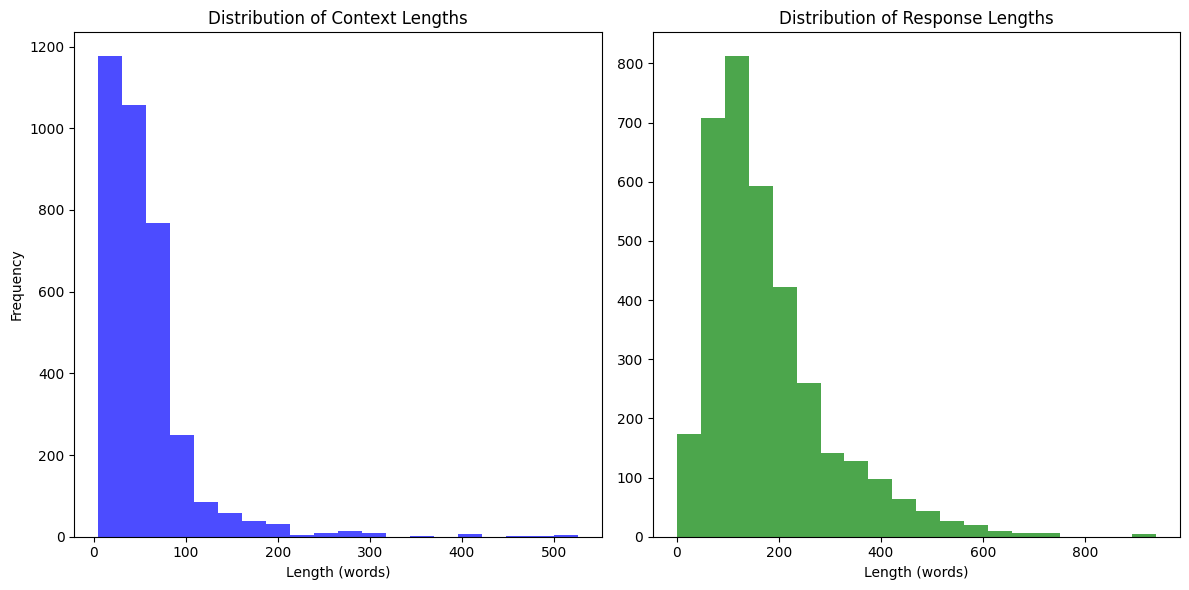

time: 545 ms (started: 2024-03-06 17:49:41 +00:00)


In [10]:
import matplotlib.pyplot as plt

# Calculate lengths
context_lengths = [len(context.split()) for context in dataset['Context']]
response_lengths = [len(response.split()) for response in dataset['Response']]

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(context_lengths, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(response_lengths, bins=20, color='green', alpha=0.7)
plt.title('Distribution of Response Lengths')
plt.xlabel('Length (words)')

plt.tight_layout()
plt.show()

# **Boxplots for Text Lengths**

This will illustrate  the median, quartiles, and outliers in the lengths of 'instruction' and 'response'.

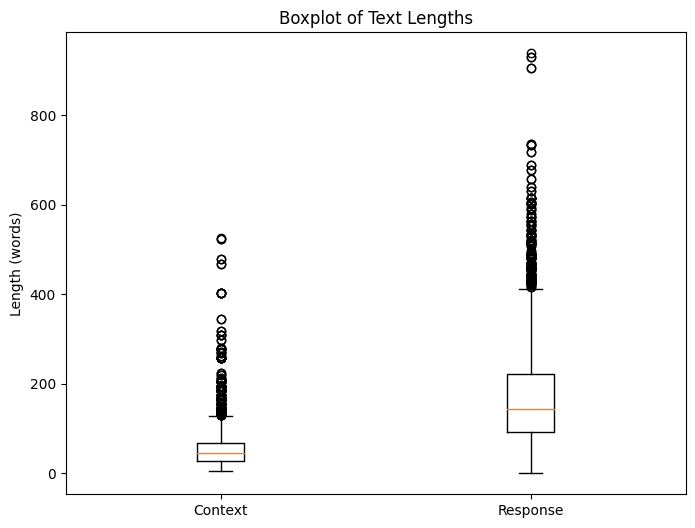

time: 140 ms (started: 2024-03-06 17:49:41 +00:00)


In [11]:
# Using the previously calculated lengths
data = [context_lengths, response_lengths]
labels = ['Context', 'Response']

plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels)
plt.title('Boxplot of Text Lengths')
plt.ylabel('Length (words)')
plt.show()


# **Scatter Plot**

Scatter plot illustrates whether there is a relationship between the length of 'instruction' and 'response'

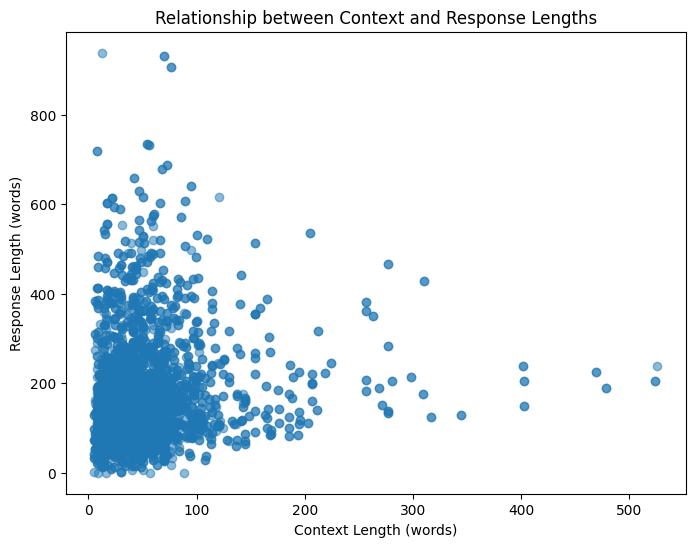

time: 223 ms (started: 2024-03-06 17:49:41 +00:00)


In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(context_lengths, response_lengths, alpha=0.5)
plt.title('Relationship between Context and Response Lengths')
plt.xlabel('Context Length (words)')
plt.ylabel('Response Length (words)')
plt.show()


To instruct tune our model, we need to convert our structured examples into a collection of tasks described via instructions. We define a formatting_function that takes a sample and returns a string with our format instruction.

In [13]:
def format_instruction(sample):
    # Format the instruction, input, and response into a single string
    formatted_text = f"""### Instruction:
Provide response for given input context.

### Input:
{sample['Context']}

### Response:
{sample['Response']}
"""
    # Return a list containing the formatted string
    return [formatted_text]


time: 494 µs (started: 2024-03-06 17:49:42 +00:00)


# **Testing Formatting Function on a Random Example**

In [14]:
from random import randrange

print(format_instruction(dataset[randrange(len(dataset))]))



["### Instruction:\nProvide response for given input context.\n\n### Input:\nMy son was diagnosed with autism a few years ago and I stopped working so that I could take care of him. I also was dealing with an abusive relationship (mentally, physically, and emotionally). Now I live like a recluse and I always feel nervous around people.\n   How can I feel more comfortable around other people?\n\n### Response:\nI'd wonder first if you were still in the same home and neighborhood where you raised your son and experienced the abuse? In many ways, we react to our environments - and if you're still surrounded by neighbors who didn't reach out when they heard your ex yelling or offer assistance and resources when your son acted differently than his peers, it might make sense that you're more timid around folks. It might also be worth thinking about where your bar is set: do you want to be as comfortable around people as you were before your recent circumstances? Or find your new normal, and c

In [15]:
print(dataset[0].keys())


dict_keys(['Context', 'Response'])
time: 595 µs (started: 2024-03-06 17:49:42 +00:00)


In [16]:
# Define the sizes of your splits
test_size = 50
validation_size = 850
train_size = len(dataset) - test_size - validation_size

# Create the splits
dataset = dataset.shuffle(seed=42)
dataset_test = dataset.select(range(test_size))
dataset_validation = dataset.select(range(test_size, test_size + validation_size))
dataset_train = dataset.select(range(test_size + validation_size, len(dataset)))

# Verify the size of each split
print(f"Training set size: {len(dataset_train)}")
print(f"Validation set size: {len(dataset_validation)}")
print(f"Test set size: {len(dataset_test)}")

Training set size: 2612
Validation set size: 850
Test set size: 50
time: 15 ms (started: 2024-03-06 17:49:42 +00:00)


# **Model Training with QLoRA and Flash Attention**

QLoRA is a technique to reduce the memory footprint of large language models during finetuning, without sacrificing performance a lot.



- We will quantize the pre-trained model to 4 bits and freeze it.
- Attach small, trainable adapter layers. (LoRA)
- Finetune only the adapter layers while using the frozen quantized model for context.

Flash Attention is a an method that reorders the attention computation and leverages classical techniques (tiling, recomputation) to significantly speed it up and reduce memory usage from quadratic to linear in sequence length.

# **Importing Necessary Libraries**

In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

time: 371 µs (started: 2024-03-06 17:49:42 +00:00)


# **Model ID Specification**

In [18]:
# Hugging Face model id
model_id = "NousResearch/Llama-2-7b-chat-hf"

time: 246 µs (started: 2024-03-06 17:49:42 +00:00)


# **BitsAndBytesConfig Setup**

In [19]:
# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

time: 1.91 ms (started: 2024-03-06 17:49:42 +00:00)


In [20]:
import torch
torch.cuda.empty_cache()


time: 384 µs (started: 2024-03-06 17:49:42 +00:00)


# **Loading Model and Tokenizer**

In [21]:
# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, use_cache=True, device_map="auto", use_flash_attention_2=True)

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

time: 53.8 s (started: 2024-03-06 17:49:42 +00:00)


In [22]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    

time: 3.99 ms (started: 2024-03-06 17:50:35 +00:00)


In [ ]:
model.config

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-chat-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,


time: 2.88 ms (started: 2024-03-06 17:37:15 +00:00)


# **Setting up Tokenizer**

In [23]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

time: 1.22 s (started: 2024-03-06 17:51:14 +00:00)


# **Configuring and Preparing Model for LoRA-based Training Using PEFT Library**

In [24]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():

        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


time: 573 µs (started: 2024-03-06 17:51:16 +00:00)


In [25]:
r = 64
LORA_ALPHA = 64
LORA_DROPOUT = 0.0

time: 365 µs (started: 2024-03-06 17:51:16 +00:00)


In [26]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# LoRA config based on QLoRA paper
peft_config = LoraConfig(
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        r=r,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules="all-linear"
)


# prepare model for training
model = prepare_model_for_kbit_training(model)



time: 26.4 ms (started: 2024-03-06 17:51:16 +00:00)


In [27]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    

In [28]:
print(model.config)

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-chat-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,


In [29]:
model = get_peft_model(model, peft_config)

time: 2.04 s (started: 2024-03-06 17:51:16 +00:00)


In [30]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit

In [31]:
print(model.config)

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-chat-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,


In [32]:
print_trainable_parameters(model)

trainable params: 159907840 || all params: 3660320768 || trainable%: 4.368683788535114
time: 7.02 ms (started: 2024-03-06 17:51:19 +00:00)


In [33]:
from datasets import Dataset, load_dataset, load_metric

time: 259 µs (started: 2024-03-06 17:51:19 +00:00)


In [34]:
!pip install -q rouge_score
!pip install -qqq evaluate --progress-bar off


  Preparing metadata (setup.py) ... done
time: 11.6 s (started: 2024-03-06 17:51:19 +00:00)


In [35]:
rouge_score = load_metric("rouge")

<ipython-input-35-3f83cc71b72a>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_score = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/main/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


time: 1.11 s (started: 2024-03-06 17:51:30 +00:00)


In [36]:
import numpy as np
from transformers import TrainingArguments
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Import evaluate from py-rouge package
import evaluate

# Initialize ROUGE metric using py-rouge
rouge_metric = evaluate.load("rouge")

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1)

def compute_metrics(eval_preds, tokenizer):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 in the preds as we can't decode them
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)

    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(pred.strip()) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip()) for label in decoded_labels]

    # Calculate ROUGE scores using py-rouge
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results and convert to percentage
    result = {key: value for key, value in result.items()}

    #smoothing function
    smoothing_function = SmoothingFunction().method4

    # Calculate BLEU score for n-grams (1 to 4)
    bleu_scores = []
    for n in range(1, 5):
        weights = (1/n,) * n
        bleu_scores_n = [corpus_bleu([[ref]], [pred], weights=weights, smoothing_function=smoothing_function) for ref, pred in zip(decoded_labels, decoded_preds)]
        bleu_scores.append(sum(bleu_scores_n) / len(bleu_scores_n))

    # Calculate mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    gen_len = np.mean(prediction_lens)

    # You can process the rouge_scores, bleu_scores, and gen_len as needed
    return {
        "rouge_scores": result,
        "bleu_scores": bleu_scores,
        "gen_len": gen_len
    }

time: 882 ms (started: 2024-03-06 17:51:31 +00:00)


# **Instantiate LoRAConfig and Prepare Model for Training**

In [37]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir= f"llama2-7b-chat-hf-mental-health",
    num_train_epochs=4,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=4,
    learning_rate=2e-4,
    report_to="wandb",
    optim="adamw_torch_fused",
    do_eval = True,
    bf16=True,
    lr_scheduler_type="cosine",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy='epoch', # log according to log_steps
    save_safetensors=True,
    push_to_hub=True,                      # push model to hub
    seed = 42
)

time: 2.2 ms (started: 2024-03-06 17:51:32 +00:00)


# **Initializing the SFTTrainer with Configuration for Model Training**

In [38]:
from huggingface_hub import notebook_login
notebook_login()

time: 21 ms (started: 2024-03-06 17:51:53 +00:00)


In [40]:
from trl import SFTTrainer

max_seq_length = 2048 # max sequence length for model and packing of the dataset

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_train,
    eval_dataset=dataset_validation,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    packing=False,
    formatting_func=format_instruction,
    compute_metrics=lambda eval_preds: compute_metrics(eval_preds, tokenizer),  # Pass the tokenizer
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    args=args,
)


Map:   0%|          | 0/2612 [00:00<?, ? examples/s]

Map:   0%|          | 0/850 [00:00<?, ? examples/s]

time: 6.31 s (started: 2024-03-06 17:52:32 +00:00)


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [41]:
!pip install -qqq wandb

time: 5.22 s (started: 2024-03-06 17:52:44 +00:00)


In [42]:
import wandb

time: 297 µs (started: 2024-03-06 17:52:49 +00:00)


In [43]:
wandb.init(project="llama2_7b_chat_hf", entity="drishtisharma96505", group='format_func_list')


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


time: 24.4 s (started: 2024-03-06 17:52:54 +00:00)


In [44]:
import time


time: 933 µs (started: 2024-03-06 17:53:19 +00:00)


In [45]:
# Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
5.301 GB of memory reserved.
time: 3.29 ms (started: 2024-03-06 17:53:19 +00:00)


In [46]:
start_time = time.time()  # Start timer

trainer_stats = trainer.train()

end_time = time.time()  # End timer
training_duration = end_time - start_time

print(f"Training Time: {training_duration} minutes")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Epoch,Training Loss,Validation Loss,Rouge Scores,Bleu Scores,Gen Len
1,2.195300,2.218420,"{'rouge1': 0.9199491740787802, 'rouge2': 0.8318809005083514, 'rougeL': 0.5854056997640226, 'rougeLsum': 0.9199491740787802}","[0.8715254358896543, 0.8659211417516524, 0.8510857228959539, 0.833791158779687]",2048.000000
2,2.023100,2.193608,"{'rouge1': 0.9096744612563045, 'rouge2': 0.8254608823259653, 'rougeL': 0.5872535534158643, 'rougeLsum': 0.9096744612563045}","[0.8550666362510422, 0.8491213000075178, 0.834566911154976, 0.8177171754641129]",2048.000000
3,1.932000,2.179011,"{'rouge1': 0.9083394562821455, 'rouge2': 0.8271173984934778, 'rougeL': 0.5857825128581924, 'rougeLsum': 0.9083394562821455}","[0.8523376774091347, 0.8462340921367671, 0.8321568176562063, 0.8159562219906903]",2048.000000
4,1.868100,2.173927,"{'rouge1': 0.9084397097988796, 'rouge2': 0.8277762468999725, 'rougeL': 0.5895858205528516, 'rougeLsum': 0.9084397097988796}","[0.8523376774091347, 0.8462340921367671, 0.8321568176562063, 0.8159562219906903]",2048.000000


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Training Time: 610.4555466175079 minutes
time: 10min 10s (started: 2024-03-06 17:53:19 +00:00)


In [47]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit

In [48]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

587.2874 seconds used for training.
9.79 minutes used for training.
Peak reserved memory = 13.953 GB.
Peak reserved memory for training = 8.652 GB.
Peak reserved memory % of max memory = 35.267 %.
Peak reserved memory for training % of max memory = 21.868 %.
time: 6.2 ms (started: 2024-03-06 18:03:29 +00:00)


# **Push to Hub**

In [51]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/DrishtiSharma/llama2-7b-chat-hf-mental-health/commit/2d9ae182ca7c4de1e3f65e88dee6ce2850796e70', commit_message='End of training', commit_description='', oid='2d9ae182ca7c4de1e3f65e88dee6ce2850796e70', pr_url=None, pr_revision=None, pr_num=None)

time: 4.89 s (started: 2024-03-06 18:05:16 +00:00)


# **Test Model and Run Inference**

### **Performing Inference on Whole Test Dataset**

In [55]:
import pandas as pd

results = []  # Initialize an empty list to store the results

# Iterate over the entire dataset_test
for sample in dataset_test:
    # Construct the prompt for each sample in the dataset
    prompt = f"""### Instruction:
    Provide response for given input context.

    ### Input:
    {sample['Context']}

    ### Response:
    """

    # Tokenize the prompt and send to the appropriate device
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()

    # Generate output using the model
    outputs = model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9, temperature=0.9)

    # Decode the generated instruction
    generated_response = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]

    # Store the prompt, generated instruction, and ground truth in the results list
    results.append({
        "Prompt": sample['Context'],
        "Generated Response": generated_response,
        "Ground Truth": sample['Response']
    })

    # Print the results for each sample
    print(f"Prompt:\n{sample['Context']}\n")
    print(f"Generated response:\n{generated_response}")
    print(f"Ground truth:\n{sample['Response']}")
    print("-----------------------------------------------------")




Prompt:
I didn't trust my wife when I found out that she had a new guy friend that she was texting and calling. I investigated him before I found out that he was gay and that there was nothing going on. Now all my wife and I do is fight about trust.

Generated response:
 I understand that you are going through a difficult time with your wife, and I can empathize with your feelings of mistrust. However, it's important to remember that making assumptions about someone's sexuality without evidence can be harmful and unfair. It's possible that your wife's friend is simply a friend, and not anything more.

     Instead of jumping to conclusions or confronting your wife without proper evidence, consider having an open and honest
Ground truth:
Instead of fighting about trust, is it possible for you and your wife to talk with other about areas which upset each of you?Whenever feelings are hurt, knowing what exactly is problematic and being heard and understood by the partner, goes a long way t

In [56]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel("test_results.xlsx", index=False)

time: 274 ms (started: 2024-03-06 18:23:15 +00:00)
